# EDA

In [1]:
import pandas as pd
import plotly.express as px
from pyprojroot import here
from sqlalchemy.engine import create_engine
from sqlalchemy.engine.url import URL
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

Base = automap_base()

## Loading data

In [2]:
engine = create_engine(
    URL(drivername="sqlite", database=str(here("data/municipal_performance.sqlite3")))
)
Base.prepare(engine, reflect=True)

In [3]:
Municipality = Base.classes.municipalities
Governorate = Base.classes.governorates
Evaluation = Base.classes.evaluations
Criterion = Base.classes.criteria

In [4]:
session = Session(engine)

In [5]:
domain_scores_2018_query = (
    session.query(
        Municipality.name_fr, Evaluation.score, Criterion.max_score, Criterion.name_fr
    )
    .filter(Evaluation.year == 2018)
    .filter(Criterion.level == "domain")
    .join(Municipality)
    .join(Criterion)
)


    .pipe(
        lambda df: df.assign(
            evaluation_score=100 * df["evaluation_score"].div(df["criterion_max_score"])
        )
    )
    .drop(columns=["criterion_max_score"])
    .pivot_table(
        index=["municipality_name_fr"],
        columns=["evaluation_criterion"],
        values=["evaluation_score"],
        aggfunc="sum",
    )
    .pipe(lambda df: df.set_axis(df.columns.get_level_values(1), axis="columns"))
    .reset_index()
    .set_index("municipality_name_fr")

In [6]:
def calculate_score(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        score=df.groupby("municipality_name_fr")["evaluation_score"].transform(sum)
    )


def calculate_criterion_pct_score(df: pd.DataFrame) -> pd.DataFrame:
    return df.pipe(
        lambda df: df.assign(
            evaluation_score=100 * df["evaluation_score"].div(df["criterion_max_score"])
        )
    )


domain_scores_2018_df = (
    pd.DataFrame(
        data=domain_scores_2018_query.all(),
        columns=[
            "municipality_name_fr",
            "evaluation_score",
            "criterion_max_score",
            "evaluation_criterion",
        ],
    )
    .pipe(calculate_score)
    .pipe(calculate_criterion_pct_score)
    .drop(columns=["criterion_max_score"])
    .pivot_table(
        index=["municipality_name_fr", "score"],
        columns=["evaluation_criterion"],
        values=["evaluation_score"],
        aggfunc="sum",
    )
    .pipe(lambda df: df.set_axis(df.columns.get_level_values(1), axis="columns"))
    .reset_index()
)
domain_scores_2018_df

evaluation_criterion,municipality_name_fr,score,Gestion,Gouvernance,Pérennité
0,Mednine,71.0,53.333333,76.666667,80.0
1,Agareb,80.0,46.666667,93.333333,95.0
2,Ain Draham,83.0,70.000000,93.333333,85.0
3,Akouda,83.0,63.333333,100.000000,85.0
4,Amirat Hojjaj,70.0,66.666667,63.333333,77.5
...,...,...,...,...,...
267,Zaouiet Sousse,86.0,53.333333,100.000000,100.0
268,Zarzis,70.0,63.333333,53.333333,87.5
269,Zarzis Nord,88.0,66.666667,93.333333,100.0
270,Zermadine,83.0,83.333333,66.666667,95.0


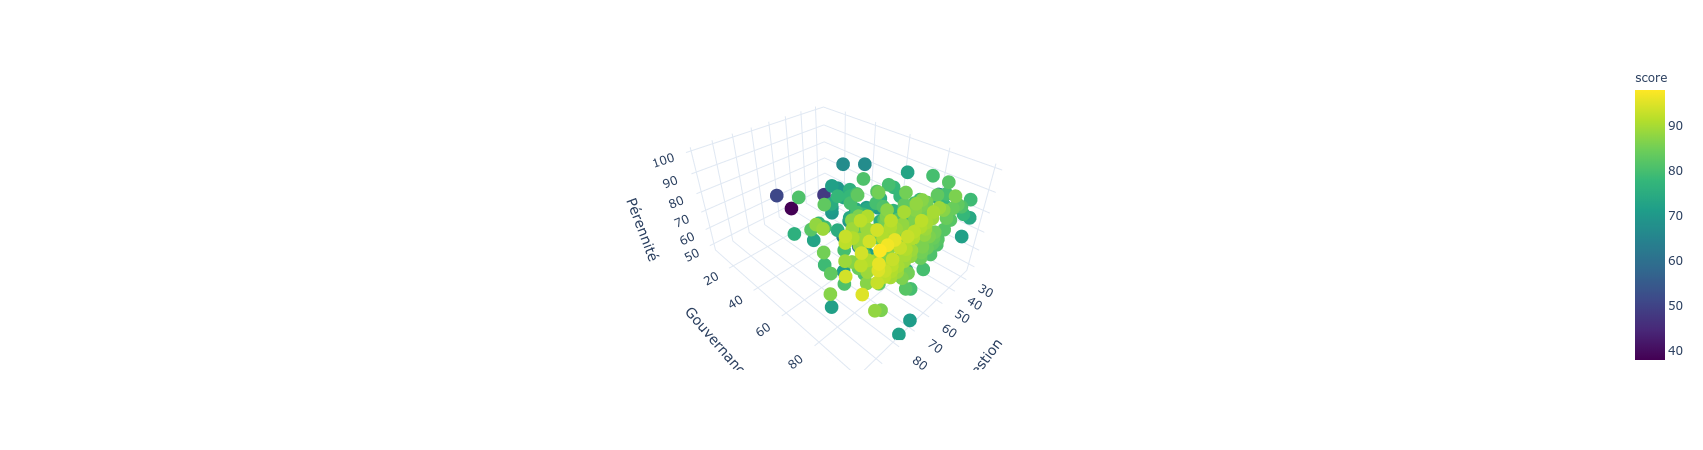

In [19]:
fig_3D = px.scatter_3d(
    domain_scores_2018_df,
    x=domain_scores_2018_df.columns[-3],
    y=domain_scores_2018_df.columns[-2],
    z=domain_scores_2018_df.columns[-1],
    hover_data=domain_scores_2018_df.columns,
    color="score",
    template="plotly_white",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig_3D

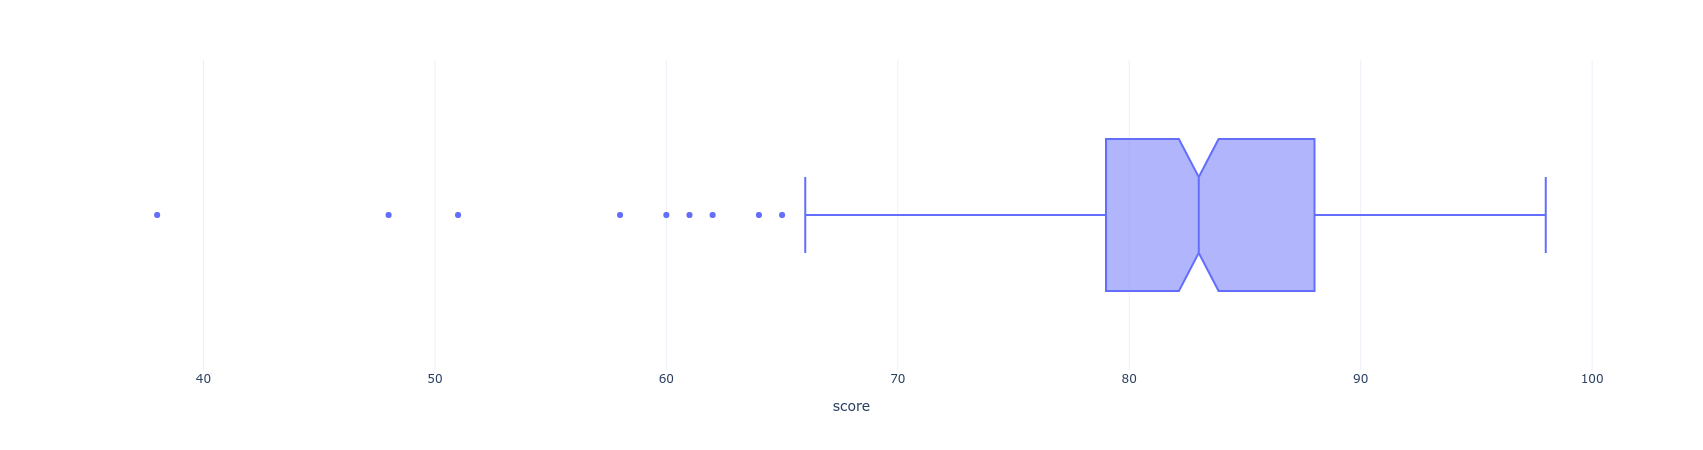

In [24]:
domain_scores_2018_df.pipe(lambda df: px.box(df, x="score", template="plotly_white", notched=True))

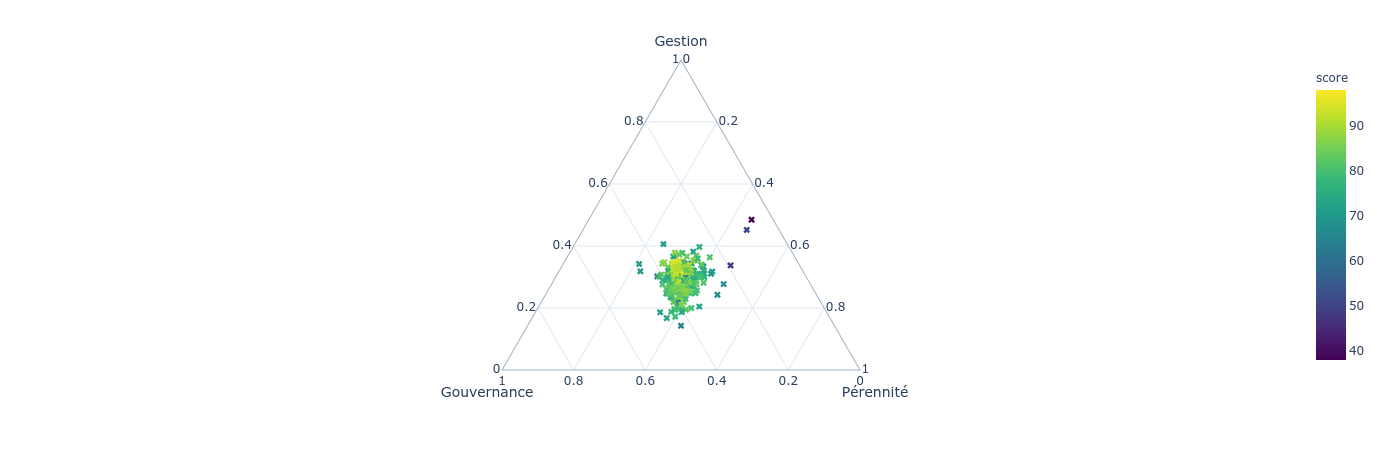

In [12]:
fig_a = px.scatter_ternary(
    domain_scores_2018_df,
    a=domain_scores_2018_df.columns[2],
    b=domain_scores_2018_df.columns[3],
    c=domain_scores_2018_df.columns[4],
    hover_data=domain_scores_2018_df.columns,
    color="score",
    template="plotly_white",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig_a.update_traces(marker=dict(symbol="x"))

In [9]:
import itertools

n = 3
fig_b = (
    pd.DataFrame(
        list(
            map(
                lambda x: dict(zip(["a", "b", "c"], x)),
                itertools.product([0, 1], repeat=n),
            )
        )
    )
    .assign(size=10)
    .pipe(
        lambda df: px.scatter_ternary(
            df, "a", "b", "c", size="size", template="plotly_white"
        )
    )
)

In [10]:
from plotly.subplots import make_subplots

In [11]:
fig = make_subplots(
    cols=3,
    specs=[[{"type": "scatterternary"}, {"type": "scatterternary"}, {"type": "scene"}]],
)

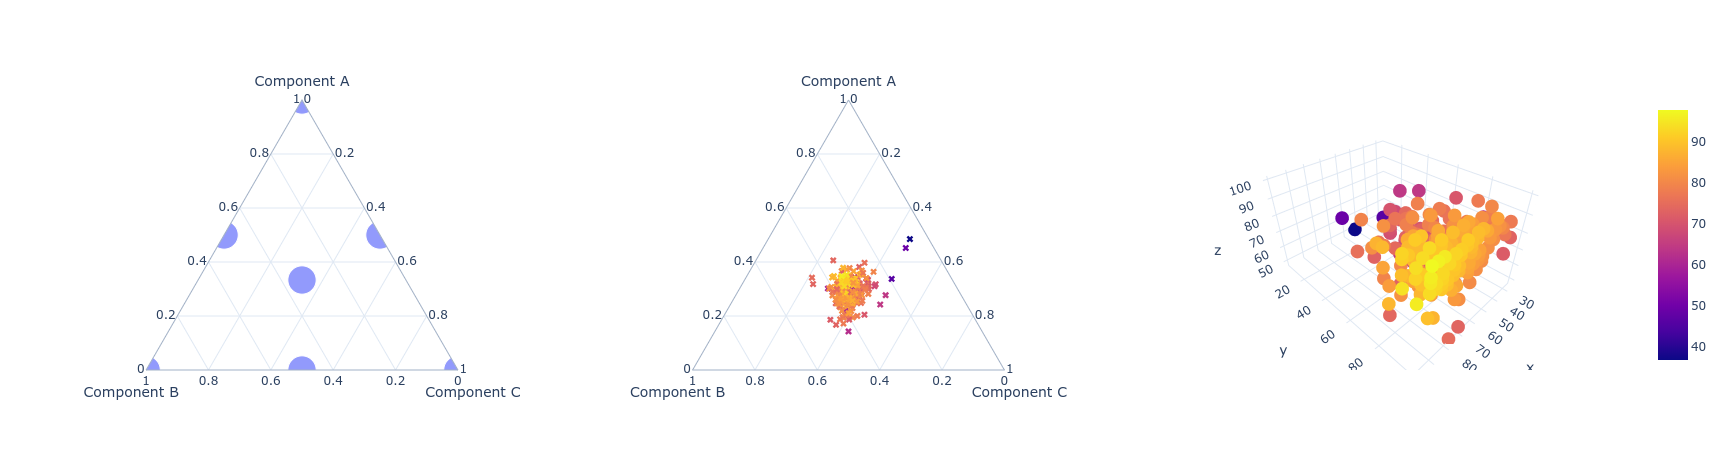

In [12]:
fig.add_trace(fig_b.data[0], row=1, col=1)
fig.add_trace(fig_a.data[0], row=1, col=2)
fig.add_trace(fig_3D.data[0], row=1, col=3)
fig.update_layout(template="plotly_white")

## t-SNE

In [13]:
q = (
    session.query(
        Municipality.name_fr, Evaluation.score, Criterion.max_score, Criterion.name_fr
    )
    .filter(Evaluation.year == 2018)
    .filter(Criterion.level == "criterion")
    .join(Municipality)
    .join(Criterion)
)
print(q)

SELECT municipalities.name_fr AS municipalities_name_fr, evaluations.score AS evaluations_score, criteria.max_score AS criteria_max_score, criteria.name_fr AS criteria_name_fr 
FROM evaluations JOIN municipalities ON municipalities.municipality_id = evaluations.municipality_id JOIN criteria ON criteria.criterion_id = evaluations.criterion_id 
WHERE evaluations.year = ? AND criteria.level = ?


In [14]:
hd_data_df = pd.DataFrame(
    data=q.all(),
    columns=[
        "municipality_name_fr",
        "evaluation_score",
        "criterion_max_score",
        "evaluation_criterion",
    ],
).pivot_table(
    index=["municipality_name_fr"],
    columns=["evaluation_criterion"],
    values=["evaluation_score"],
)

In [38]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [61]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(hd_data_df)

In [62]:
pca = PCA(n_components="mle")
pca.fit(X_scaled)
pca_df = pd.DataFrame(
    pca.transform(X_scaled), columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
)

In [63]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,0.820564,0.925585,-0.205871,0.055268,-0.591350,-0.296527,0.622895,-0.205647,-0.315192,0.215502,...,0.168559,-0.173708,-0.032601,-0.179426,-0.047861,-0.054048,-0.079024,0.155453,-0.032311,-0.024168
1,0.477705,-0.289712,1.059669,0.285103,-0.298602,-0.159379,-0.199781,-0.339472,0.306039,-0.075576,...,0.069038,0.043967,0.249825,-0.175524,-0.111841,0.003528,-0.042868,-0.168802,-0.000606,0.021913
2,-0.001954,0.126982,-0.389999,-0.505984,-0.052678,0.044338,-0.251579,-0.453052,0.193761,0.169168,...,0.145716,0.210226,-0.291544,0.120461,-0.464688,0.627325,0.091349,-0.069652,-0.370835,-0.079010
3,0.345346,0.033759,-0.290994,-0.199573,0.188775,-0.761193,0.077304,0.230446,-0.167659,-0.062726,...,0.054435,0.154984,0.087867,0.022800,0.065171,0.083162,0.029694,-0.034927,-0.046093,-0.058555
4,-0.309811,0.808604,-0.150237,0.351240,1.185112,-0.519659,0.327024,-0.545745,-0.333506,0.188849,...,0.135118,-0.013536,-0.034383,-0.163030,0.081937,-0.073512,-0.015834,-0.009043,0.003579,-0.016253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,1.146974,-0.430809,0.420034,-0.161428,-0.467103,0.174940,-0.054277,-0.127635,0.163568,0.190570,...,-0.126835,-0.058951,-0.090005,-0.074191,-0.150539,-0.065325,-0.039609,0.067193,0.024391,0.027372
268,0.017444,1.420373,-0.033050,-0.228777,-0.252160,0.664840,0.050658,0.456602,0.326808,0.656394,...,-0.368984,0.362135,0.152754,-0.231921,0.171587,-0.022736,0.041123,-0.095313,0.012448,-0.035465
269,-0.464891,-0.086266,0.606792,-0.397672,-0.131082,-0.060923,-0.255078,-0.043688,-0.052942,-0.064436,...,0.146902,0.200858,0.114462,-0.042204,0.025338,0.016564,0.004655,-0.060881,-0.046249,0.012968
270,-0.545412,0.136403,0.304371,-0.231616,0.336364,0.676481,0.713275,-0.721543,-0.204659,-0.393669,...,-0.359524,0.149261,0.046323,-0.070354,0.075557,-0.052999,-0.031097,-0.037707,-0.002653,0.006957


In [64]:
pca.explained_variance_ratio_

array([0.12389735, 0.11780677, 0.09102927, 0.08121126, 0.06770843,
       0.06372732, 0.05929504, 0.05237264, 0.04232589, 0.0401333 ,
       0.03685697, 0.03167739, 0.03015684, 0.02336846, 0.02074524,
       0.01969821, 0.01730076, 0.016633  , 0.01331967, 0.01315883,
       0.01144013, 0.00905288, 0.00723807, 0.00495116, 0.00354142])

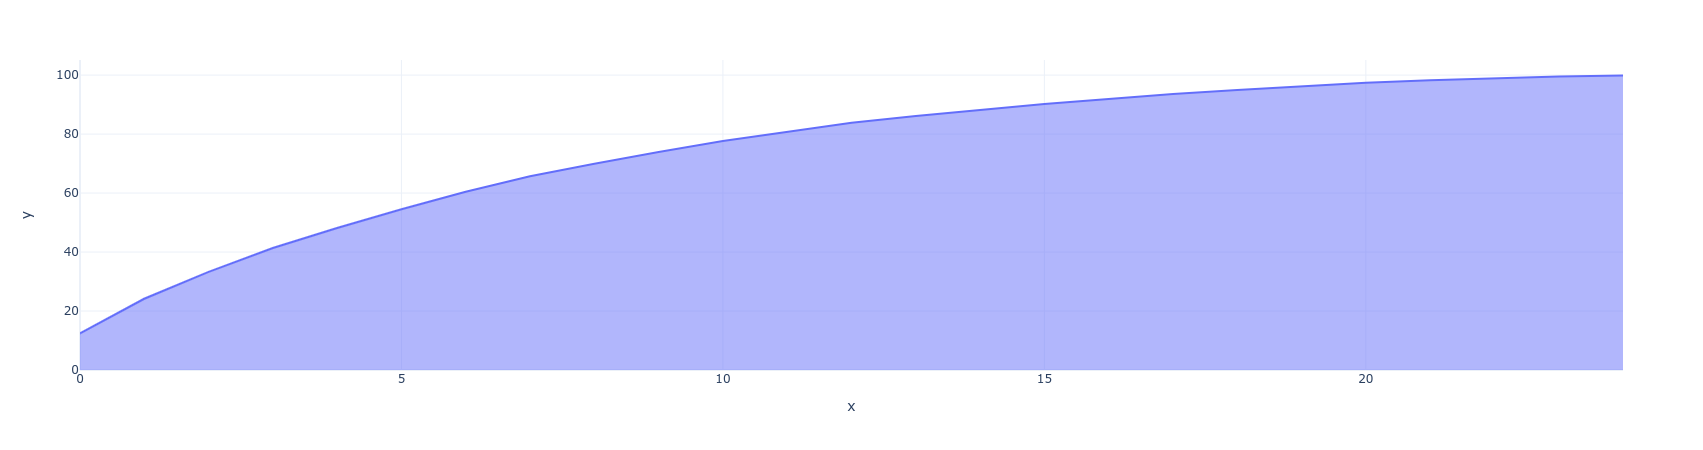

In [65]:
px.area(y=100 * pca.explained_variance_ratio_.cumsum(), template="plotly_white")

In [66]:
varimax_pca = FactorAnalyzer(n_factors=25, rotation="varimax", method="principal")
varimax_pca.fit(X_scaled)
varimax_pca_df = pd.DataFrame(
    varimax_pca.transform(X_scaled),
    columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)],
)

In [67]:
calculate_kmo(X_scaled)

/home/iyed/.pyenv/versions/3.7.0/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



(array([0.52714042, 0.4998998 , 0.50443988, 0.53098001, 0.64906166,
        0.77646604, 0.56920928, 0.45268133, 0.53083065, 0.60043198,
        0.55483552, 0.50764033, 0.62705203, 0.59112726, 0.53716499,
        0.6742611 , 0.64250215, 0.65397681, 0.72384633, 0.58885038,
        0.61590722, 0.50686537, 0.47607036, 0.57210354, 0.58974225,
        0.4831662 ]),
 0.5912197566089442)

In [68]:
calculate_bartlett_sphericity(X_scaled)

(943.197599149499, 4.825015860943803e-62)

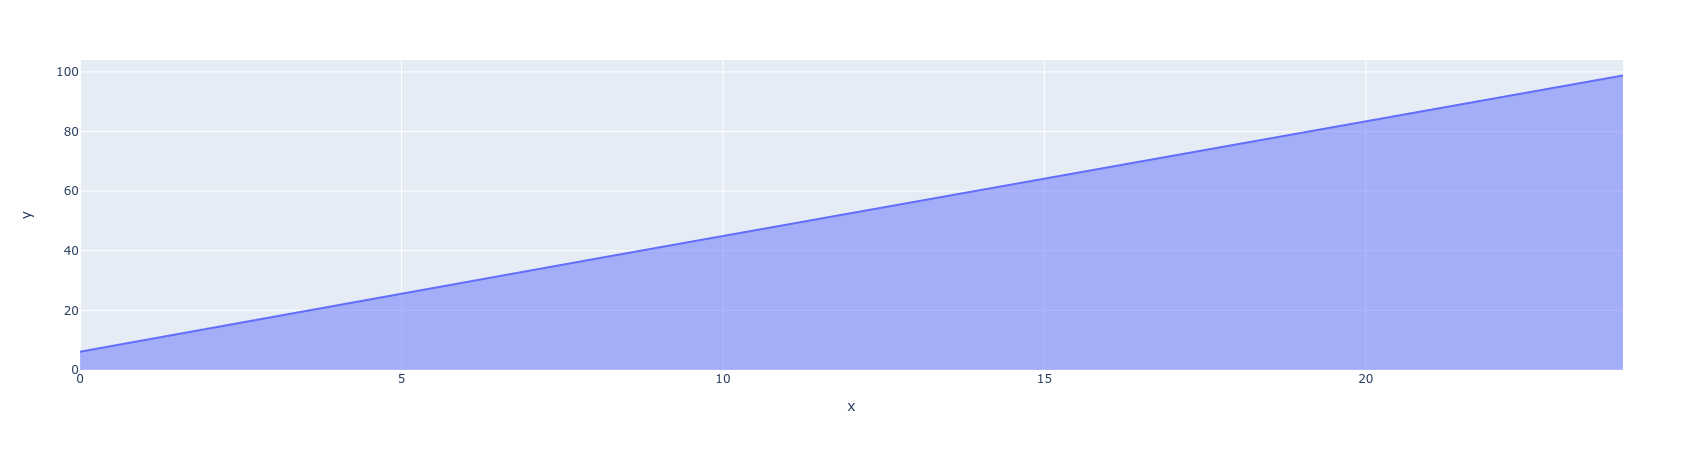

In [69]:
_, _, explained_variance_cumsum = varimax_pca.get_factor_variance()
px.area(y=100 * explained_variance_cumsum)

In [70]:
original_eigen_values, common_factor_eigen_values = varimax_pca.get_eigenvalues()

In [71]:
common_factor_eigen_values

array([2.92597   , 1.80050606, 1.64679883, 1.60745624, 1.47121525,
       1.30830614, 1.26549762, 1.2029612 , 1.10893254, 1.01486702,
       0.98276425, 0.93064785, 0.87746908, 0.82736787, 0.81767691,
       0.79786966, 0.73034355, 0.6831324 , 0.63994908, 0.53894364,
       0.51857285, 0.49410041, 0.47157368, 0.43776618, 0.37430738,
       0.20553892])

In [72]:
spec_clust = SpectralClustering(n_clusters=3)
spec_clust.fit(varimax_pca_df)

SpectralClustering(n_clusters=3)

In [73]:
agg_clust = AgglomerativeClustering(
    n_clusters=3, compute_full_tree=True, linkage="complete"
)
agg_clust.fit(varimax_pca_df)

AgglomerativeClustering(compute_full_tree=True, linkage='complete',
                        n_clusters=3)

In [74]:
kmeans_clust = KMeans(n_clusters=3)
kmeans_clust.fit(varimax_pca_df)

KMeans(n_clusters=3)

In [83]:
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(varimax_pca_df.iloc[:, :10])

In [84]:
spec_fig = px.scatter_3d(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    z=tsne_results[:, 2],
    color=[str(i) for i in spec_clust.labels_],
    height=700,
    width=700,
)
agg_fig = px.scatter_3d(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    z=tsne_results[:, 2],
    color=[str(i) for i in agg_clust.labels_],
    height=700,
    width=700,
)
kmeans_fig = px.scatter_3d(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    z=tsne_results[:, 2],
    color=[str(i) for i in kmeans_clust.labels_],
    height=700,
    width=700,
)

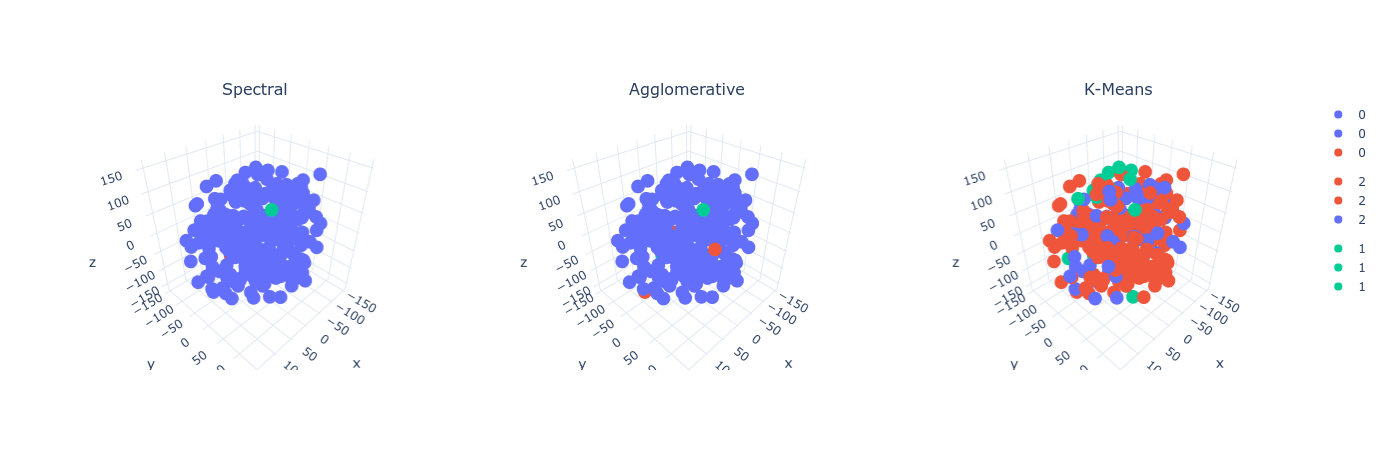

In [85]:
fig = make_subplots(
    cols=3,
    shared_xaxes="all",
    shared_yaxes="all",
    subplot_titles=["Spectral", "Agglomerative", "K-Means"],
    specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
)
fig.add_traces(spec_fig.data, cols=1, rows=1)
fig.add_traces(agg_fig.data, cols=2, rows=1)
fig.add_traces(kmeans_fig.data, cols=3, rows=1)
fig.update_layout(template="plotly_white")

In [88]:
spec_fig_pca = px.scatter(
    x=tsne_results[:, 1],
    y=tsne_results[:, 2],
    color=[str(i) for i in spec_clust.labels_],
    height=700,
    width=700,
)
agg_fig_pca = px.scatter(
    x=tsne_results[:, 1],
    y=tsne_results[:, 2],
    color=[str(i) for i in agg_clust.labels_],
    height=700,
    width=700,
)
kmeans_fig_pca = px.scatter(
    x=tsne_results[:, 1],
    y=tsne_results[:, 2],
    color=[str(i) for i in kmeans_clust.labels_],
    height=700,
    width=700,
)

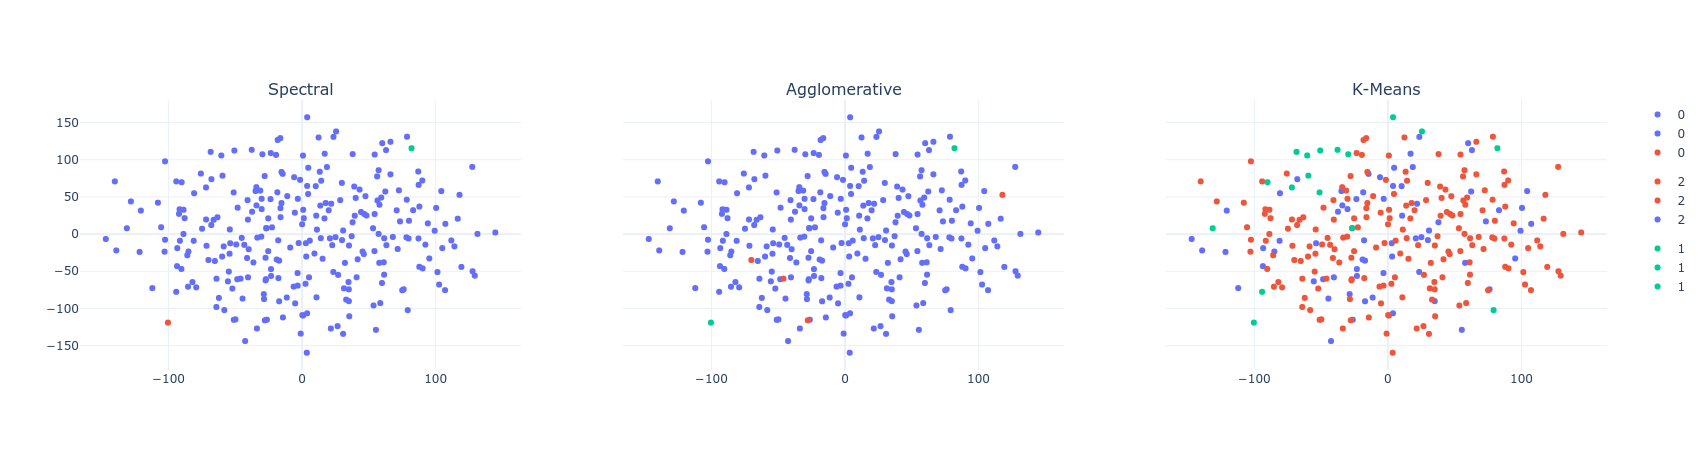

In [89]:
fig = make_subplots(
    cols=3,
    shared_xaxes=True,
    shared_yaxes=True,
    subplot_titles=["Spectral", "Agglomerative", "K-Means"],
    specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]],
)
fig.add_traces(spec_fig_pca.data, cols=1, rows=1)
fig.add_traces(agg_fig_pca.data, cols=2, rows=1)
fig.add_traces(kmeans_fig_pca.data, cols=3, rows=1)
fig.update_layout(template="plotly_white")

In [90]:
labels = agg_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled, labels))

Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Coefficient: 0.133


In [91]:
labels = spec_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled, labels))

Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Coefficient: 0.366
